# Storytelling for [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)
---

Instructions for this exercise:

> Get going by asking the following questions and looking for the answers with some code and plots:
>
> * Can you count something interesting?
> 
> * Can you find some trends (high, low, increase, decrease, anomalies)?
> 
> * Can you make a bar plot or a histogram?
> 
> * Can you compare two related quantities?
> 
> * Can you make a scatterplot?
> 
> * Can you make a time-series plot?
> 
> Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?
> 
> By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?

---

In [1]:
# load all datasets, then merge and clean them to be used:
import lib.clean_db as clean_db

df = clean_db.load_from('data') # 'data': directory that contains .csv files

#print('>>> df shape=', df.shape)
#display(df.head(2))

A Jupyter Widget

In [2]:
# must import remaining modules after clean_db.load_from() to be able to visualize the progress bar
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

## 1. Where are the restaurants?
Even though not every restaurant in the database has geographic coordinates associated with them, it's still interesting to see where in the world these observations were registered.

In [3]:
# count the percentage of missing geographical coordinates (lat/lon)
missing_percent = df[df['latitude'] <= 0].shape[0] / df.shape[0] * 100
print('>>>', round(missing_percent, 2), '% of geographical data is missing.')

# keep the only unique pairs of latitude/longitude: i.e. one geographical reference per location
unique_coords_df = df.drop_duplicates(subset=['latitude', 'longitude'], keep='first', inplace=False)
print('>>> Ploting map with', unique_coords_df.shape[0], 'different geographic locations.')
#display(unique_coords_df)

# setup Folium close to Japan
japan_map = folium.Map(location=[37.6, 139.5], zoom_start=5, tiles="Stamen Terrain")

for _, row in unique_coords_df.iterrows():
    popup_msg = 'Area: ' + row['area_name'] + '<br>Genre: ' + row['genre_name']
    folium.CircleMarker(location=[row['latitude'], row['longitude']], popup=popup_msg, radius=4, color='#000000', weight=0.6, opacity=1.0, fill=True, fill_color='#ff5733', fill_opacity=1.0).add_to(japan_map)

display(japan_map)

>>> 0.0 % of geographical data is missing.
>>> Ploting map with 108 different geographic locations.


## 2. Which are the most visited areas?
It's clear from the previous map that most (if it not all) of the data comes from japanese restaurants. So which of these are the most visited locations?

In [4]:
start_date = df['visit_date'].min()
end_date = df['visit_date'].max()
print('>>> Analysing data from', start_date, 'to', end_date)

# create DataFrame to store the result of the groupby(): #visitors_df = df.groupby(['latitude', 'longitude'])['visitors'].agg('sum')
visitors_df = pd.DataFrame({'total_visitors' : df.groupby(["latitude", "longitude"])['visitors'].agg('sum')}).reset_index()

# sort rows by the amount of visitors
visitors_df.sort_values('total_visitors', ascending=False, inplace=True)

# discard rows with lat/lon == -1
visitors_df = visitors_df[visitors_df['latitude'] >= 0]  

max_value = visitors_df['total_visitors'].iloc[0]
print('>>> Largest historical concentration of visitors in a single venue:', max_value)

# setup Folium close to Japan
japan_map = folium.Map(location=[37.6, 139.5], zoom_start=5, tiles="Stamen Terrain")

###
# display regular map with markers
###
# for _, row in visitors_df.iterrows():
#     circle_sz = row['total_visitors'] / max_value * 50
#     popup_msg = 'From ' + start_date + ' to ' + end_date + '<br>' + str(str(row['total_visitors']) + ' visits')
#     folium.CircleMarker(location=[row['latitude'], row['longitude']], popup=popup_msg, radius=circle_sz, color='#000000', weight=0.6, opacity=1.0, fill=True, fill_color='#ffd800', fill_opacity=0.8).add_to(japan_map)

###
# display heat map
###    
from folium.plugins import HeatMap
heat_data = [[row['latitude'],row['longitude']] for index, row in visitors_df.iterrows()]
HeatMap(heat_data).add_to(japan_map)   
    
display(japan_map)

>>> Analysing data from 2016-01-01 to 2017-04-22
>>> Largest historical concentration of visitors in a single venue: 400275


## 3. Is there more activity during weekends and holidays?
One might be forgiven to think that restaurants receives more visitation during weekends and holidays. The following plot shows that this is not a rule. We should probably check every restaurant individually later.

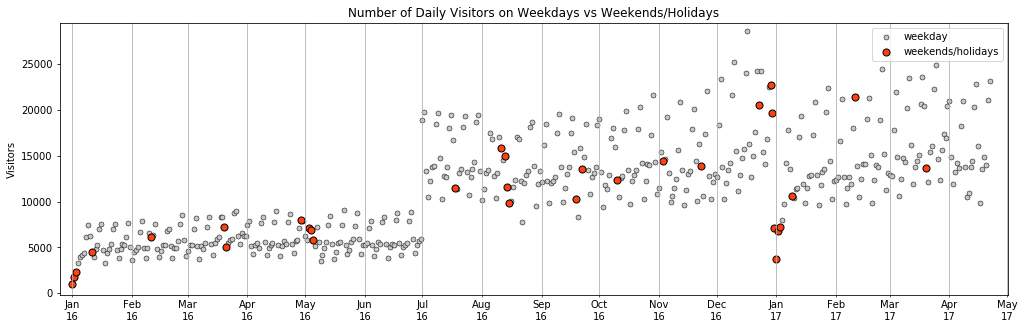

In [5]:
import matplotlib.dates as mdates
#df = df.tail(1000)
# is jan 03 really holiday?
#display(df[df.visit_date == '2016-01-03'].head())

daily_df = df
daily_df = daily_df.set_index('visit_date')
daily_df.index = pd.to_datetime(daily_df.index)

daily_df = daily_df.resample('D').sum()
# display(daily_df.head(5))

# drop unecessary columns
daily_df = daily_df.drop(['latitude', 'longitude'], axis=1)

# update holiday values >= 1 to just 1
daily_df.loc[daily_df['holiday_flg'] > 0, 'holiday_flg'] = 1
#display(daily_df.head(5))

####
# plot the number of visits per day, coloring by weekday and weekends/holidays
###
fig, ax = plt.subplots(figsize=(17,5))
for klass, row in daily_df.groupby('holiday_flg'):
    c = 'weekday'
    class_color = 'xkcd:silver'
    marker_sz = 25
    linew = 0.5
    if (klass == 1): 
        c = 'weekends/holidays'
        class_color = 'xkcd:orangered'
        marker_sz = 50
        linew = 1
    ax.scatter(row.index, row.visitors, label=c, s=marker_sz, color=class_color, lw=linew, edgecolors='black')
    
ax.legend()
#ax.set_facecolor('xkcd:gray') # background color
ax.set_title('Number of Daily Visitors on Weekdays vs Weekends/Holidays')
#ax.set_xlabel('Dates')
ax.set_ylabel('Visitors')
ax.margins(0, 0.03) # set margins to avoid "whitespace" while showing the first x-tick
ax.xaxis.grid(True, which="minor")

# set monthly xticks: major ticks are hidden and minor ticks display month/year information:
months = plt.matplotlib.dates.MonthLocator()
plt.gca().xaxis.set_minor_locator(months)
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%y'))
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))
plt.gca().xaxis.set_major_locator(plt.NullLocator())

plt.show()

## 4. What are the most popular genres of restaurants?

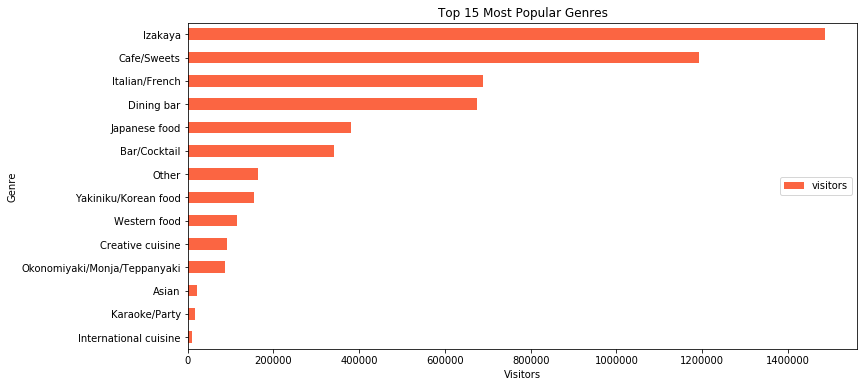

In [6]:
# as_index=False converts the result of a groupby() to a DataFrame object
popular_genre_df = df.groupby('genre_name', as_index=False).visitors.sum()

# replace empty cell value for 'Unknown'
popular_genre_df.loc[popular_genre_df['genre_name'] == '', 'genre_name'] = 'Unknown genre'

# sort by visitors
popular_genre_df.sort_values('visitors', inplace=True, ascending=True)

#reset index to genre strings
popular_genre_df = popular_genre_df.set_index('genre_name')
# display(popular_genre_df.head(10))

ax = popular_genre_df.tail(15).plot(kind='barh', figsize=(12,6), title='Top 15 Most Popular Genres', color='#fb6542')
ax.set_ylabel("Genre")
ax.set_xlabel("Visitors")

plt.legend(loc="center right")
plt.show()

## 5. Which restaurants have the most visitors?

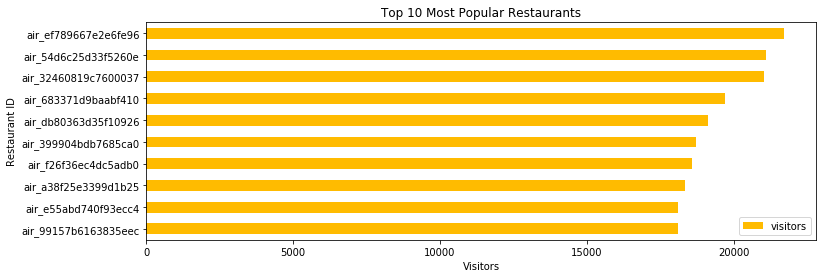

In [7]:
# as_index=False converts the result of a groupby() to a DataFrame object
popular_restaurants_df = df.groupby(['air_store_id'], as_index=False).visitors.sum()

# sort by visitors
popular_restaurants_df.sort_values('visitors', inplace=True, ascending=True)

#reset index to genre strings
popular_restaurants_df = popular_restaurants_df.set_index(['air_store_id'])
#display(popular_restaurants_df.tail(3))

# grab the top 10 from the DataFrame
popular_restaurants_df = popular_restaurants_df.tail(10)

ax = popular_restaurants_df.plot(kind='barh', figsize=(12,4), title='Top 10 Most Popular Restaurants', color='#ffbb00')
ax.set_ylabel("Restaurant ID")
ax.set_xlabel("Visitors")

plt.show()

One restaurant ID may have more than one geographical coordinates associated with it. This means an ID probably identifies a a chain of restaurants instead of a single one. In this case, multiple occurences of an ID with a different set of coordinates represent locations of restaurants that belong to that same chain. 

This means a restaurant ID from the Top 10 list may be in fact data collected across a number of restaurants from the same restaurant chain.

Next, all the *Top 10 Most Popular Restaurants* that have valid coordinates are plotted on the map.

In [8]:
# Retrieve lat/lon information from the original DataFrame for every restaurant in the Top 10 list!
# Note that some restaurant's IDs may have more than one lat/lon associated with them.
# This part of the code also copies all these occurences of different lat/lon coordinates to final DataFrame.
popular_restaurants_df = popular_restaurants_df.reset_index()
#display(popular_restaurants_df.head())

def add_geocoord_columns(df1, df2):    
    # copy only ['latitude', 'longitude'] to result
    result = pd.merge(df1, df2[['air_store_id', 'latitude', 'longitude']], on='air_store_id', how='left')
    
    result = result.drop_duplicates()
    print('>>> result   shape=', result.shape)

    return result
    
# add correspondent lat/long columns from the original DataFrame    
%time rest_loc_df = add_geocoord_columns(popular_restaurants_df, df)

# print('rest_loc_df  shape=', rest_loc_df.shape)
#display(rest_loc_df.head(10))

>>> result   shape= (10, 4)
Wall time: 32.1 ms


In [9]:
# create a list of colors for the Top 10 restaurants
color_list = [ 'red', 'purple', 'cadetblue', 'blue', 'darkred', 'orange', 'lightgreen', 'green', 'pink', 'lightblue' ]
num_uniq_ids = len(rest_loc_df.drop_duplicates().groupby(['air_store_id']).size())

# make sure there are not more restaurants than colors
print('num_uniq_ids=', num_uniq_ids, 'len(color_list)=', len(color_list))
assert (num_uniq_ids <= len(color_list))

# setup Folium close to Japan
japan_map = folium.Map(location=[37.6, 139.5], zoom_start=5, tiles="Stamen Terrain")

# run through all the IDs, associate a unique color with each unique restaurant ID.
color_map = { }
color_idx = 0
for _, row in rest_loc_df.iterrows():
    ids = row['air_store_id']
    if (ids not in color_map):
        color_map[ids] = color_list[color_idx]
        color_idx += 1

    color = color_map[ids]
    folium.CircleMarker(location=[row['latitude'], row['longitude']], popup=ids, radius=10, color='#000000', weight=0.6, opacity=1.0, fill=True, fill_color=color, fill_opacity=1.0).add_to(japan_map)

display(japan_map)

num_uniq_ids= 10 len(color_list)= 10


## 6. How many restaurants are active on a monthly basis?
It seems the number of restaurants participating in the AIR and HPG systems increase over time. The following plot shows the total number of restaurants active every month to try to visualize this trend.

In [10]:
# add a new column named 'month_year' with just that part of visit_date
df.visit_date = pd.to_datetime(df.visit_date)
df['month_year'] = df.loc[:,'visit_date'].dt.to_period('M')

In [11]:
monthly_df = df
# print('monthly_df  shape (before)=', monthly_df.shape)

# drop rows to keep a single entry for every restaurant (per month)
print('>>> Please wait ~1min while data is being processed...')
monthly_df = monthly_df.drop_duplicates(subset=['air_store_id', 'latitude', 'longitude', 'month_year']) 
monthly_df = monthly_df.drop_duplicates(subset=[ 'latitude', 'longitude', 'month_year']) 

print('>>> ... done!')

#display(monthly_df.head(5))
#print('monthly_df  shape  (after)=', monthly_df.shape)

result_df = pd.DataFrame({'freq' : monthly_df.groupby(['month_year']).size()})
result_df.index = result_df.index.map(lambda x: x.strftime('%Y-%b'))
result_df.index = pd.to_datetime(result_df.index)

#display(result_df.tail())
#print('result_df   shape  (after)=', monthly_df.shape)

>>> Please wait ~1min while data is being processed...
>>> ... done!


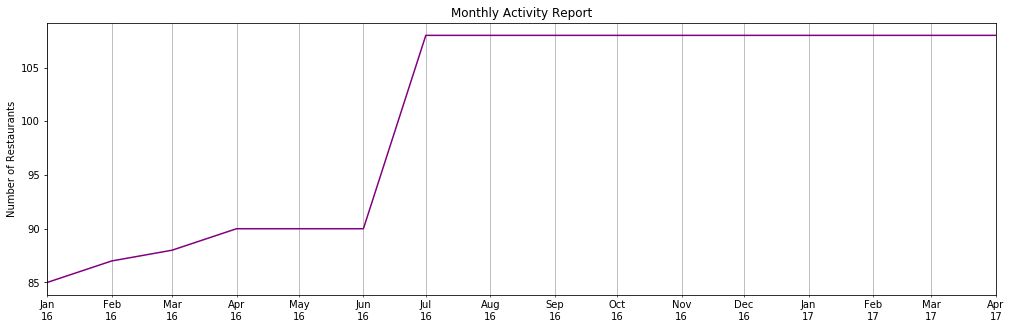

In [12]:
fig, ax = plt.subplots(figsize=(17,5))

# Pandas plot() ruins the xticks! Alternative method: use matplotlib's plot_date() and configure xticks by hand:
plt.plot(result_df.index, result_df.freq, color='purple')

ax.set_title('Monthly Activity Report')
#ax.set_xlabel('Dates')
ax.set_ylabel('Number of Restaurants')
ax.margins(0, 0.05) # set margins to avoid "whitespace" while showing the first x-tick
ax.xaxis.grid(True, which="minor")

# set monthly xticks: major ticks are hidden and minor ticks display month/year information:
months = plt.matplotlib.dates.MonthLocator()
plt.gca().xaxis.set_minor_locator(months)
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%y'))
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))
plt.gca().xaxis.set_major_locator(plt.NullLocator())

plt.show()